In [39]:
import numpy as np
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [40]:
# Constants
R = 1.5         # radius of source point circle
N = 1500        # number of source points
M = 1500        # number of boundary points
k = np.sqrt(3)  # wavenumber

d = np.array([0, 1, 1]) / np.sqrt(2)  # direction vector
def v(z):
  return np.exp(1j * k * (z @ d))

In [41]:
# Evenly distribute points on a sphere
# https://arxiv.org/pdf/0912.4540.pdf
def sphere(npoints):
  golden_ratio = (1 + 5 ** 0.5) / 2
  i = np.arange(0, npoints)
  phi = np.arccos(1 - (2 * i + 1) / npoints)
  theta = 2 * np.pi * i / golden_ratio
  x = np.sin(phi) * np.cos(theta)
  y = np.sin(phi) * np.sin(theta)
  z = np.cos(phi)
  return np.column_stack((x, y, z))

# Source points
y = R * sphere(N)

# Boundary points
x = sphere(M)

# Form matrix A
r = np.linalg.norm(x[:, None] - y, axis=2)
A = np.exp(-1j * k * r) / r

# Solve least-squares problem for alpha
alpha, _, _, _ = lstsq(A, v(x))

In [42]:
# Create a meshgrid of points on the unit sphere for evaluation
theta = np.linspace(0, 2 * np.pi, 200)
phi = np.linspace(0, np.pi, 200)
theta, phi = np.meshgrid(theta, phi)
x_plot = np.sin(phi) * np.cos(theta)
y_plot = np.sin(phi) * np.sin(theta)
z_plot = np.cos(phi)
pts = np.stack((x_plot, y_plot, z_plot), axis=-1)

# Compute approximation u^(N)
r = np.linalg.norm(pts[..., None, :] - y, axis=-1)
u_N = np.sum(alpha * np.exp(-1j * k * r) / r, axis=-1)

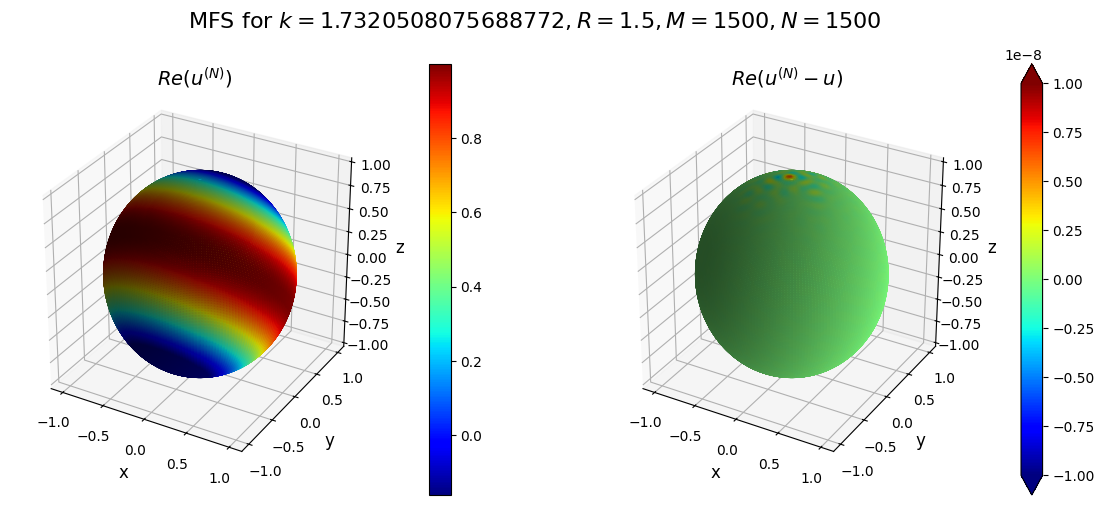

In [43]:
# Prepare subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7),
                               subplot_kw={'projection': '3d'})
fig.suptitle(f"MFS for $k={k}, R={R}, M={M}, N={N}$", fontsize=16, y=0.88)

# Plot the approximated solution
f = np.real(u_N)
surf1 = ax1.plot_surface(x_plot, y_plot, z_plot, facecolors=plt.cm.jet(f),
                         rstride=1, cstride=1, antialiased=True, alpha=0.01)
ax1.set_title("$Re(u^{(N)})$", fontsize=14)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_zlabel('z', fontsize=12)
ax1.set_box_aspect([1, 1, 1])
mappable1 = plt.cm.ScalarMappable(cmap=plt.cm.jet)
mappable1.set_array(f)
plt.colorbar(mappable1, aspect=20, ax=ax1, pad=0.1, shrink=0.8)

# Plot the error from the exact solution
vmin, vmax = -1e-8, 1e-8  # bounds for error clipping
f_err = np.real(u_N - v(pts))
norm = colors.Normalize(vmin=vmin, vmax=vmax)
facecolors = plt.cm.jet(norm(f_err))
surf2 = ax2.plot_surface(x_plot, y_plot, z_plot,
                         facecolors=facecolors,
                         rstride=1, cstride=1, antialiased=True, alpha=0.01)
ax2.set_title("$Re(u^{(N)} - u)$", fontsize=14)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_zlabel('z', fontsize=12)
ax2.set_box_aspect([1, 1, 1])
mappable2 = plt.cm.ScalarMappable(cmap=plt.cm.jet)
mappable2.set_clim(vmin, vmax)
plt.colorbar(mappable2, aspect=20, ax=ax2, pad=0.1, shrink=0.8, extend='both')

plt.show()

<ipython-input-44-5ee5a16dd6d6>:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


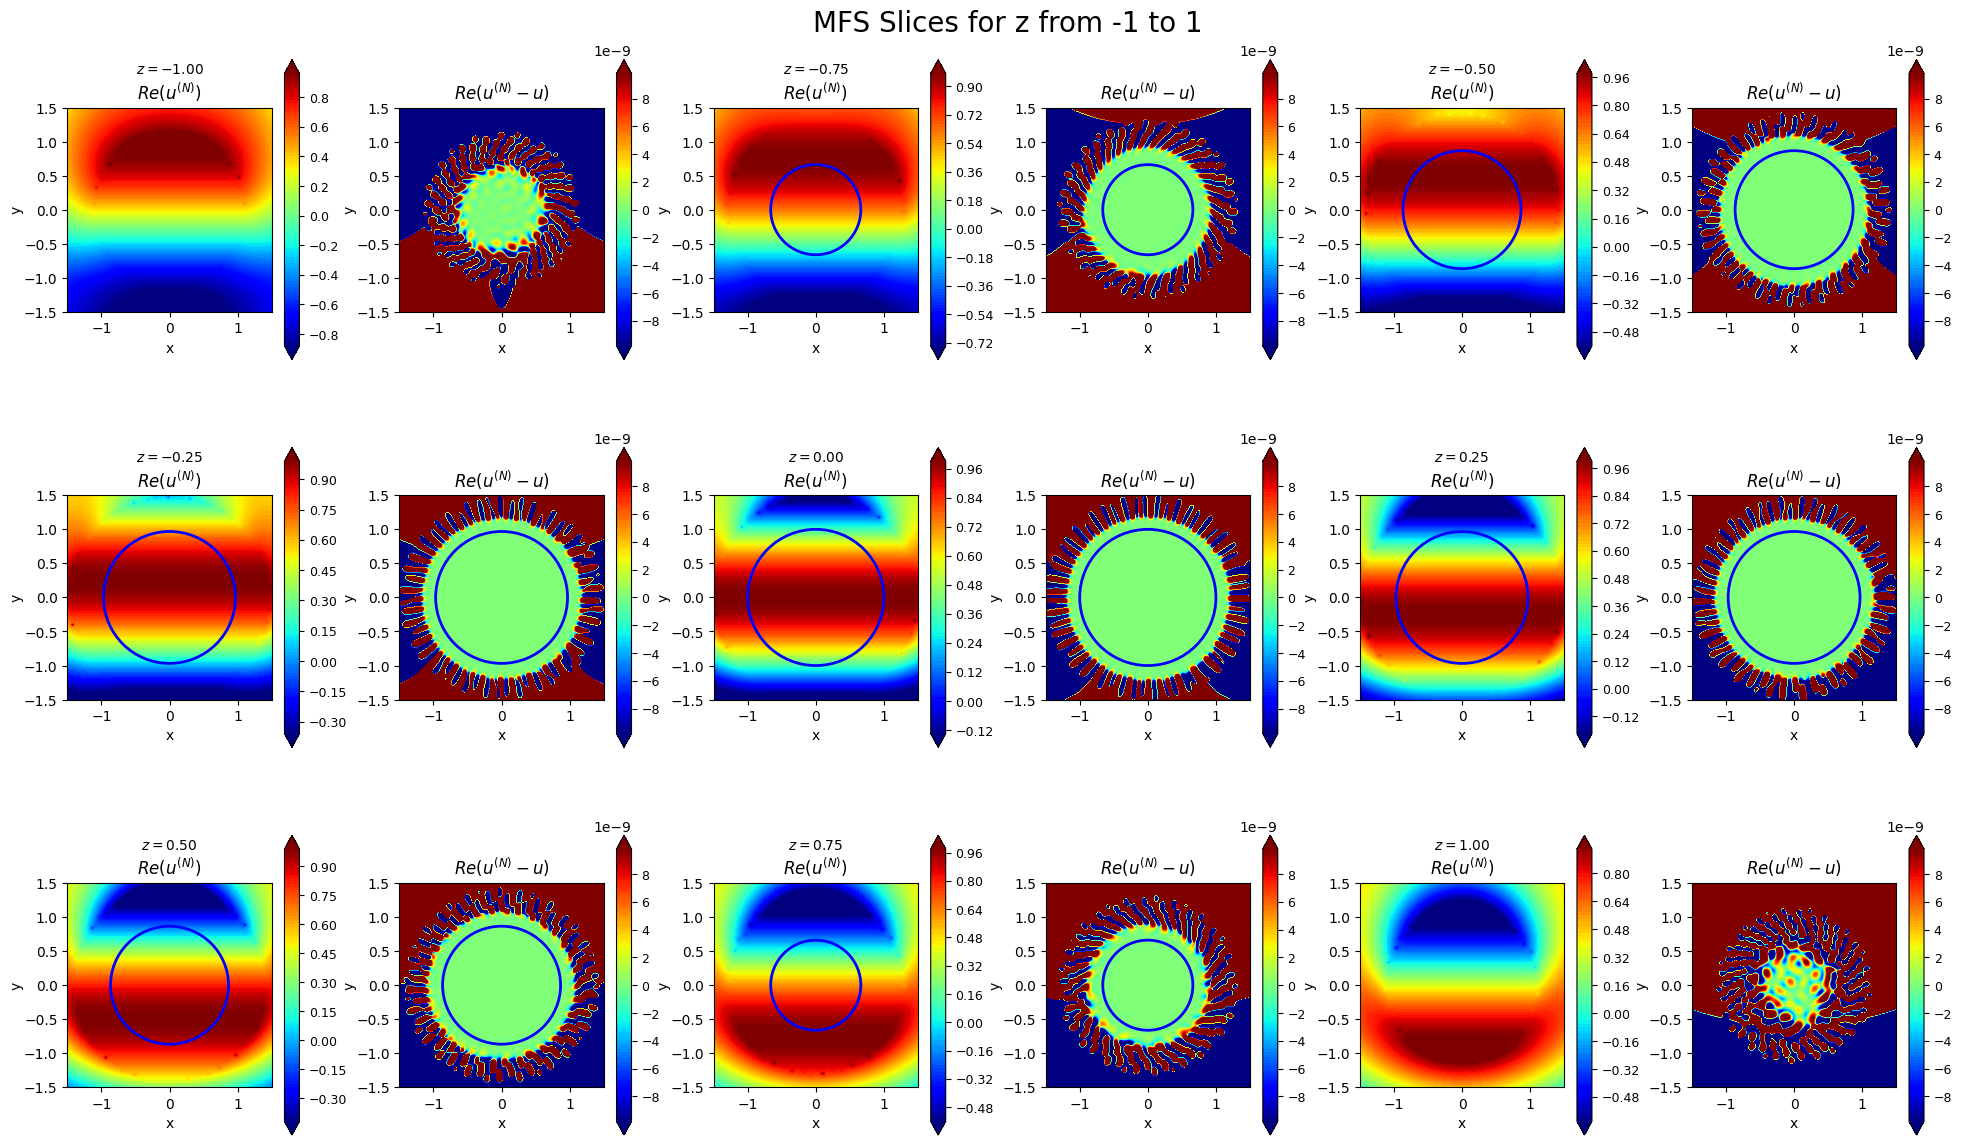

In [44]:
z_slices = np.linspace(-1, 1, 9)
opts = {"levels": 100, "cmap": "jet", "extend": "both"}

fig = plt.figure(figsize=(20, 12))
outer_gs = GridSpec(3, 3, left=0.03, right=0.97, top=0.97, bottom=0.03,
                     wspace=0.1, hspace=0.1)

for i, z in enumerate(z_slices):
  # Prepare subplots
  inner_gs = GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[i], wspace=0.3)
  ax1 = fig.add_subplot(inner_gs[0])  # Left: MFS approximation
  ax2 = fig.add_subplot(inner_gs[1])  # Right: Error plot

  # Create evaluation grid
  grid = np.linspace(-R, R, 200)
  X, Y = np.meshgrid(grid, grid)
  pts = np.dstack((X, Y, np.full(X.shape, z)))

  # Compute u^(N)
  r = np.linalg.norm(pts[..., None, :] - y, axis=-1)
  u = np.sum(alpha * np.exp(-1j * k * r) / r, axis=-1)

  # Plot MFS approximation, omitting singularities outside the domain
  sol_data = np.real(u)
  vmin_sol, vmax_sol = np.percentile(sol_data, [5, 95])
  sol_clipped = np.clip(sol_data, vmin_sol, vmax_sol)
  cs1 = ax1.contourf(X, Y, sol_clipped,
                      norm=plt.Normalize(vmin=vmin_sol, vmax=vmax_sol), **opts)

  # Plot error
  err = np.real(u - v(pts)).clip(vmin, vmax)
  cs2 = ax2.contourf(X, Y, err, **opts)

  # Add outline circles
  circle1 = plt.Circle((0, 0), np.sqrt(1 - z**2),
                        color='blue', fill=False, lw=2)
  circle2 = plt.Circle((0, 0), np.sqrt(1 - z**2),
                        color='blue', fill=False, lw=2)
  ax1.add_patch(circle1)
  ax2.add_patch(circle2)

  # Set equal aspect ratio
  ax1.set_aspect('equal', 'box')
  ax2.set_aspect('equal', 'box')

  # Set titles
  ax1.set_title("$Re(u^{(N)})$", fontsize=12)
  ax2.set_title("$Re(u^{(N)}-u)$", fontsize=12)

  # Set axis labels
  ax1.set_xlabel("x", fontsize=10)
  ax1.set_ylabel("y", fontsize=10, labelpad=0)
  ax2.set_xlabel("x", fontsize=10)
  ax2.set_ylabel("y", fontsize=10, labelpad=0)

  # Add z-slice label
  ax1.text(0.5, 1.15, f"$z={z:.2f}$", transform=ax1.transAxes,
            fontsize=10, ha="center", va="bottom")

  # Add colorbars
  cbar1 = plt.colorbar(cs1, ax=ax1, shrink=0.85, pad=0.05)
  cbar2 = plt.colorbar(cs2, ax=ax2, shrink=0.85, pad=0.05)
  cbar1.ax.tick_params(labelsize=9)
  cbar2.ax.tick_params(labelsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.suptitle("MFS Slices for z from -1 to 1", fontsize=20, y=0.99)
plt.show()

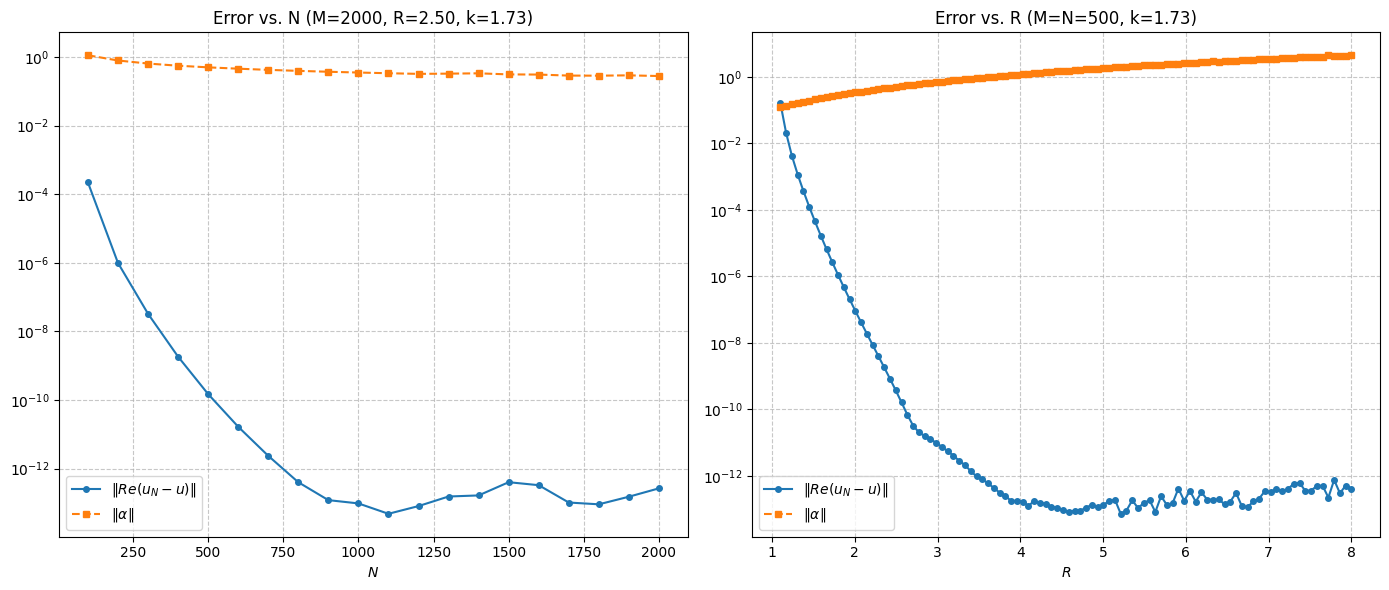

In [48]:
# Create evaluation grid
n_eval_theta = 50
n_eval_phi = 50
theta = np.linspace(0, 2 * np.pi, n_eval_theta)
phi = np.linspace(0, np.pi, n_eval_phi)
Theta, Phi = np.meshgrid(theta, phi)
x_eval = np.stack((np.sin(Phi) * np.cos(Theta),
                   np.sin(Phi) * np.sin(Theta),
                   np.cos(Phi)), axis=-1)

def mfs(M, N, R, source_func):
  """
  Computes the L2 error of the real parts on the evaluation grid and
  the norm of the source strengths alpha, given:
    M           : number of boundary points
    N           : number of source points
    R           : sphere scaling factor for the source points
    source_func : source point generating function
  """
  # Boundary and source points
  x = source_func(M)
  y = source_func(N) * R

  # Assemble MFS matrix
  r = np.linalg.norm(x[:, None, :] - y[None, :, :], axis=2)
  A = np.exp(-1j * k * r) / r

  # Solve for alpha
  alpha, _, _, _ = lstsq(A, v(x))

  # Evaluate the MFS approximation on the evaluation grid
  r_eval = np.linalg.norm(x_eval[..., None, :] - y, axis=-1)
  u_approx = np.sum(alpha * (np.exp(-1j * k * r_eval) / r_eval), axis=-1)

  # Compute the normalized L2 error (real part)
  err = np.real(u_approx) - np.real(v(x_eval))
  return np.linalg.norm(err), np.linalg.norm(alpha)

# Variation with respect to N for fixed R
R_fixed = 2.5
M_fixed = 2000
N_vals = np.arange(100, M_fixed + 1, 100)
err_N, alpha_N = [], []
for N in N_vals:
  err, a_norm = mfs(M_fixed, N, R_fixed, sphere)
  err_N.append(err)
  alpha_N.append(a_norm)

# Variation with respect to R (with M = N fixed)
M_default = 500
R_vals = np.linspace(1.1, 8, 100)
err_R, alpha_R = [], []
for R_val in R_vals:
  err, a_norm = mfs(M_default, M_default, R_val, sphere)
  err_R.append(err)
  alpha_R.append(a_norm)

# Prepare subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot: Error and alpha-norm vs. N for fixed R
ax1.semilogy(N_vals, err_N, 'o-', markersize=4, label=r"$\|Re(u_N-u)\|$")
ax1.semilogy(N_vals, alpha_N, 's--', markersize=4, label=r"$\|\alpha\|$")
ax1.set_xlabel(r"$N$")
ax1.set_title(f"Error vs. N (M={M_fixed}, R={R_fixed:.2f}, k={k:.2f})")
ax1.legend()
ax1.grid(True, which="both", linestyle="--", alpha=0.7)

# Plot: Error and alpha-norm vs. R for fixed M = N
ax2.semilogy(R_vals, err_R, 'o-', markersize=4, label=r"$\|Re(u_N-u)\|$")
ax2.semilogy(R_vals, alpha_R, 's--', markersize=4, label=r"$\|\alpha\|$")
ax2.set_xlabel(r"$R$")
ax2.set_title(f"Error vs. R (M=N={M_default}, k={k:.2f})")
ax2.legend()
ax2.grid(True, which="both", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

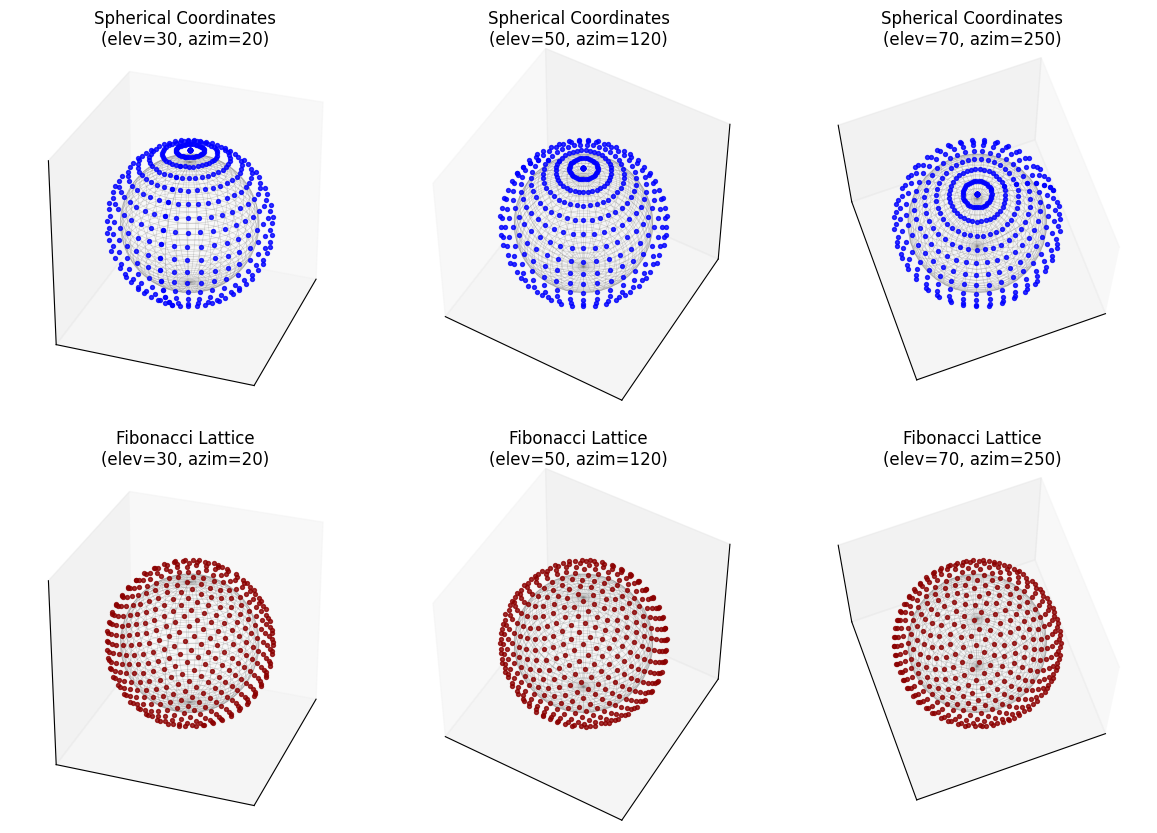

In [49]:
# Using spherical coordinates
def spherical_points(n_theta, n_phi, flatten=False):
  theta = np.linspace(0, np.pi, n_theta)
  phi = np.linspace(0, 2 * np.pi, n_phi)
  Theta, Phi = np.meshgrid(theta, phi, indexing='ij')
  X = np.sin(Theta) * np.cos(Phi)
  Y = np.sin(Theta) * np.sin(Phi)
  Z = np.cos(Theta)
  if flatten:
    return np.stack((X, Y, Z), axis=-1).reshape(n_theta * n_phi, 3)
  return X, Y, Z

# Set parameters and generate boundary mesh
boundary_radius, source_radius = 1.0, 1.2
viewpoints = [(30, 20), (50, 120), (70, 250)]
X_b, Y_b, Z_b = spherical_points(40, 40)

# Spherical coordinates points
n_theta, n_phi = 20, 40
sc_points = spherical_points(n_theta, n_phi, flatten=True) * source_radius

# Fibonacci lattice points
n_points = n_theta * n_phi
fb_points = sphere(n_points) * source_radius

# Plot the boundary and source points from multiple viewpoints
fig, axarr = plt.subplots(2, len(viewpoints), subplot_kw={'projection': '3d'},
                           figsize=(5 * len(viewpoints), 10))
plt.subplots_adjust(wspace=0.05, hspace=0.2)
for row, pts, label, color in [(0, sc_points, "Spherical Coordinates", "blue"),
                               (1, fb_points, "Fibonacci Lattice", "darkred")]:
  for j, (elev, azim) in enumerate(viewpoints):
    ax = axarr[row, j]
    ax.plot_wireframe(X_b, Y_b, Z_b, color="grey", alpha=0.3, linewidth=0.5)
    ev = np.radians(elev)
    az = np.radians(azim)
    view_vector = np.array([np.cos(ev) * np.cos(az),
                            np.cos(ev) * np.sin(az),
                            np.sin(ev)])
    visible = pts[pts.dot(view_vector) > 0]
    ax.scatter(visible[:, 0], visible[:, 1], visible[:, 2],
               s=8, c=color, alpha=0.8, depthshade=False)
    ax.set_title(f"{label}\n(elev={elev}, azim={azim})", fontsize=12)
    ax.view_init(elev, azim)
    ax.set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), zlim=(-1.5, 1.5))
    ax.set_box_aspect([1, 1, 1])
    ax.set_xticks([]), ax.set_yticks([]), ax.set_zticks([])

plt.show()

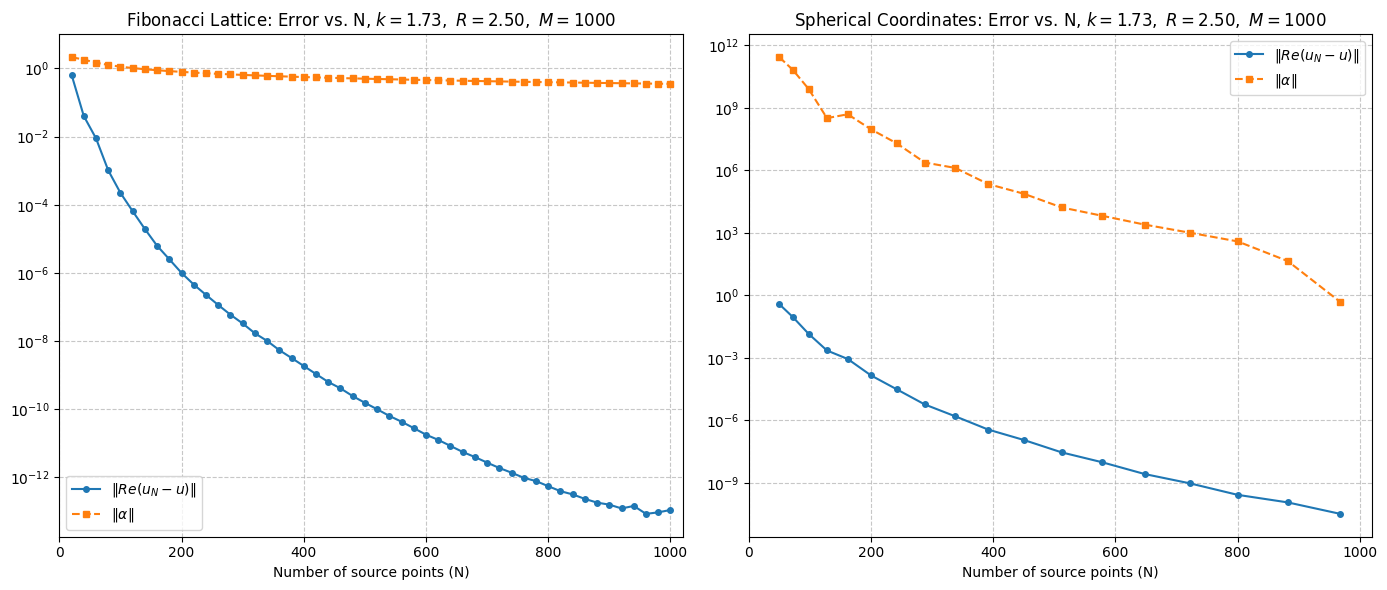

In [50]:
# Fixed MFS parameters
M_fixed = 1000
R_fixed = 2.5

# Generate spherical source points with n_phi ≈ 2*n_theta
# Total source points = 2*n_theta²
def spherical_source_points(N):
  n_theta = int(np.sqrt(N / 2))
  n_phi = 2 * n_theta
  return spherical_points(n_theta, n_phi, flatten=True)

# Vary N for Fibonacci while ensuring N <= M_fixed
N_fib_vals = np.arange(20, M_fixed+1, 20)
err_fib, alpha_fib = [], []
for N in N_fib_vals:
  e, a = mfs(M_fixed, N, R_fixed, sphere)
  err_fib.append(e)
  alpha_fib.append(a)

# Vary N for spherical while ensuring N = 2*n_theta² <= M_fixed
n_theta_vals = np.arange(5, int(np.floor(np.sqrt(M_fixed/2)))+1)
N_sph_vals = 2 * (n_theta_vals**2)
err_sph, alpha_sph = [], []
for n_theta in n_theta_vals:
  N = 2 * n_theta**2
  e, a = mfs(M_fixed, N, R_fixed, spherical_source_points)
  err_sph.append(e)
  alpha_sph.append(a)

# Prepare subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot semilog graph for Fibonacci
ax1.semilogy(N_fib_vals, err_fib, 'o-', markersize=4, label=r"$\|Re(u_N-u)\|$")
ax1.semilogy(N_fib_vals, alpha_fib, 's--', markersize=4, label=r"$\|\alpha\|$")
ax1.set_xlabel("Number of source points (N)")
ax1.set_title(r"Fibonacci Lattice: Error vs. N, $k=%.2f,\ R=%.2f,\ M=%d$"
               % (k, R_fixed, M_fixed))
ax1.set_xlim(0, M_fixed + 20)
ax1.legend()
ax1.grid(True, which="both", ls="--", alpha=0.7)

# Plot semilog graph for spherical
ax2.semilogy(N_sph_vals, err_sph, 'o-', markersize=4, label=r"$\|Re(u_N-u)\|$")
ax2.semilogy(N_sph_vals, alpha_sph, 's--', markersize=4, label=r"$\|\alpha\|$")
ax2.set_xlabel("Number of source points (N)")
ax2.set_title(r"Spherical Coordinates: Error vs. N, $k=%.2f,\ R=%.2f,\ M=%d$"
               % (k, R_fixed, M_fixed))
ax2.set_xlim(0, M_fixed + 20)
ax2.legend()
ax2.grid(True, which="both", ls="--", alpha=0.7)

plt.tight_layout()
plt.show()